In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [2]:
#get the list of cities and Lat Long, also population number from the dataset in csv format
#the data is acquired from https://worldpopulationreview.com/countries/cities/indonesia
df = pd.read_csv("indonesia_cities.csv")
df.shape

(384, 4)

In [3]:
df.head()

,City,Population,Lat,Lng
0,Jakarta,8540121,-6.21462,106.8450
1,Surabaya,2374658,-7.24917,112.7510
2,Medan,1750971,3.58333,98.6667
3,Bandung,1699719,-6.92222,107.6070
4,Bekasi,1520119,-6.23490,106.9900


In [4]:
#now show the map and the markers
import folium
import matplotlib.colors as colors
#the center location is Jakarta
map = folium.Map(location=[-6.21462,106.84513], zoom_start=4)
for index,row in df.iterrows():
    color = "#6060ff"
    folium.CircleMarker(
        [row["Lat"], row["Lng"]],
        radius=2,
        popup=str(row["City"]),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(map)
map

In [ ]:
#get the number of recommended venues in each city using foursquare API
import json
from urllib import request
def getVenues(lat,lng):
    apiresult = request.urlopen(
        "https://api.foursquare.com/v2/venues/search?v=20210126&client_id=IKE5IUMRJQOFKU4OPT5VGWE434RGHUV1CCYFLUY2ODYYQE1F&client_secret=E4ORZYBW5S3DSSG2YXZBUEM1B23332NXNMWZL30H2TN405VL&ll="+str(lat)+","+str(lng)
    ).read()
    res = json.loads(apiresult)
    return res["response"]["venues"]

#put the number of venues in the df
df["Num Venues"] = 0
for index,row in df.iterrows():
    venues = getVenues(row["Lat"],row["Lng"])
    df.loc[index,"Num Venues"]=len(venues)

In [6]:
df.head()

,City,Population,Lat,Lng,Num Venues
0,Jakarta,8540121,-6.21462,106.8450,0
1,Surabaya,2374658,-7.24917,112.7510,0
2,Medan,1750971,3.58333,98.6667,0
3,Bandung,1699719,-6.92222,107.6070,0
4,Bekasi,1520119,-6.23490,106.9900,0


In [7]:
#cluster the cities into 10
kclusters = 10
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=kclusters)
kmeans.fit(df[["Lat","Lng"]])
kmeans.labels_

array([0, 3, 2, 0, 0, 5, 0, 1, 0, 6, 0, 5, 5, 3, 0, 0, 3, 5, 1, 6, 3, 7,
       6, 0, 7, 8, 1, 5, 8, 1, 3, 2, 5, 3, 1, 9, 0, 0, 6, 0, 2, 6, 3, 2,
       6, 0, 1, 2, 0, 0, 0, 0, 0, 1, 0, 5, 0, 9, 0, 6, 6, 0, 3, 0, 0, 6,
       0, 0, 0, 3, 3, 2, 2, 0, 0, 6, 0, 5, 7, 0, 0, 8, 5, 2, 1, 3, 0, 4,
       5, 6, 3, 3, 7, 2, 1, 0, 6, 0, 6, 3, 0, 5, 8, 0, 0, 3, 0, 6, 5, 3,
       0, 2, 6, 6, 0, 0, 3, 0, 6, 0, 0, 3, 0, 0, 6, 5, 2, 2, 7, 8, 1, 6,
       2, 0, 5, 6, 1, 5, 0, 6, 0, 3, 0, 5, 6, 0, 3, 2, 0, 6, 0, 0, 6, 6,
       3, 6, 0, 1, 1, 3, 0, 2, 3, 3, 6, 0, 9, 3, 3, 0, 6, 3, 5, 3, 6, 0,
       0, 6, 5, 6, 3, 3, 6, 9, 6, 6, 7, 5, 3, 3, 3, 6, 0, 4, 3, 6, 6, 3,
       7, 6, 1, 3, 6, 6, 6, 1, 0, 6, 3, 2, 6, 3, 5, 5, 6, 6, 7, 3, 6, 6,
       2, 3, 4, 5, 9, 0, 3, 6, 6, 6, 0, 6, 2, 3, 9, 6, 0, 9, 6, 5, 0, 3,
       1, 7, 8, 3, 9, 1, 2, 5, 6, 6, 2, 6, 6, 6, 4, 6, 3, 0, 3, 9, 6, 0,
       3, 5, 1, 1, 2, 6, 2, 0, 4, 6, 6, 6, 3, 6, 7, 1, 6, 0, 5, 3, 8, 9,
       7, 6, 3, 3, 2, 9, 0, 3, 7, 5, 3, 6, 0, 6, 8,

In [8]:
#create colors from red to green
#green indicates the best potential cluster for business, with the lowest value of venue/population
colors = ["DF5C24","CD6629","BF6E2D","AC7933","AA7A33",
"9B8238","898C3D","6A9D46","5BA64B","4FAD4F"]

In [9]:
#put the cluster labels in the df
df["Cluster"] = 0
for index,row in df.iterrows():
    df.loc[index,"Cluster"]=kmeans.labels_[index]
df.head()

,City,Population,Lat,Lng,Num Venues,Cluster
0,Jakarta,8540121,-6.21462,106.8450,0,0
1,Surabaya,2374658,-7.24917,112.7510,0,3
2,Medan,1750971,3.58333,98.6667,0,2
3,Bandung,1699719,-6.92222,107.6070,0,0
4,Bekasi,1520119,-6.23490,106.9900,0,0


In [10]:
#calculate VP for each cluster (venue/population)
#lower VP indicates that there are still a few number of venues if compared to the population count in that cluster
vp = pd.DataFrame(data={"Cluster":np.arange(0,kclusters),"VP":np.zeros(kclusters)})
vp["Color"]=""
for i in range(0,kclusters):
    #VP in percent
    vp.loc[i,"VP"] = 100*df[df["Cluster"]==i]["Num Venues"].sum()/df[df["Cluster"]==i]["Population"].sum()
#assign the colors, where red represents high VP (bad), green represents low VP (good)
vp.sort_values("VP",inplace=True)
vp.set_index(np.arange(0,kclusters),inplace=True)
for i in range(0,kclusters):
    vp.loc[i,"Color"] = colors[kclusters-i-1]
vp

,Cluster,VP,Color
0,0,0.0,4FAD4F
1,1,0.0,5BA64B
2,2,0.0,6A9D46
3,3,0.0,898C3D
4,4,0.0,9B8238
5,5,0.0,AA7A33
6,6,0.0,AC7933
7,7,0.0,BF6E2D
8,8,0.0,CD6629
9,9,0.0,DF5C24


In [11]:
#now redraw the map with the clusters and the green color for low VP, and red color for high VP
import folium
import matplotlib.colors as colors
#the center location is Jakarta
map = folium.Map(location=[-6.21462,106.84513], zoom_start=4)
for index,row in df.iterrows():
    #get the color from the VP table
    color = "#"+vp[vp["Cluster"]==row["Cluster"]].iloc[0]["Color"]
    folium.CircleMarker(
        [row["Lat"], row["Lng"]],
        radius=2,
        popup=str(row["City"]),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(map)
map

<b>In case the map doesn't appear (in GitHub), here is the final generated map
This map clearly shows the green areas where there's still a lot of potential to open new business, since the number of venues are still low if compared to the population.
<br>On the other hand, red areas have already a lot of venues if compared to population.
<br>Thus, for example, one potential area is West Java area.
</b>

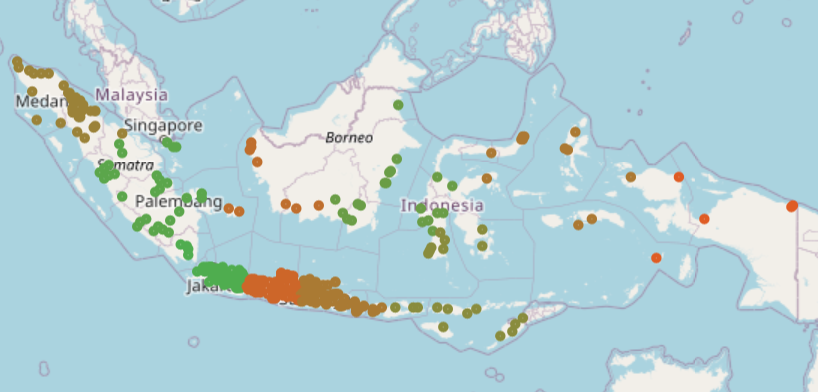